# Detection of interictal periods in EEG signals using machine learning

## Processing of databases

## Prepare the environment

### Install requirements

In [ ]:
!pip install -r ../requirements.txt

### Global variables

In [1]:
PATH_DATASET = "./datasets"
PATH_SCRIPTS = "./scripts"
PATH_RESULTS = "./results"

### Import libraries

import sys
sys.path.append(PATH_SCRIPTS)
from load_data import extract_data

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import entropy as shannon_entropy
from scipy.stats import skew, kurtosis
import pywt

import sys
sys.path.append(PATH_SCRIPTS)
from load_data import extract_data

## Loading datasets

In [4]:
raw_path = PATH_DATASET +"/Raw_data.zip"

dataset= extract_data(raw_path)
for key, value in dataset.items():
    print(f"{key}: {len(value)}")

F: 100
N: 100
O: 100
S: 100
Z: 100
interictal: 50
preictal: 50
ictal: 50


## calculation of main characteristics for each signal
Activity, mobility, complexity, energy, entropy, standard deviation, kurtosis, zero crossings, label calculation

In [5]:
def hjorth_parameters(signal: np.ndarray):
    """
    Computes Hjorth parameters for a 1-D signal:
      • Activity   = var(y)
      • Mobility   = √(var(y') / var(y))
      • Complexity = √(var(y'') / var(y')) / Mobility
    """
    activity = np.var(signal)
    dy = np.diff(signal)
    var_dy = np.var(dy)
    mobility = np.sqrt(var_dy / activity)
    ddy = np.diff(dy)
    var_ddy = np.var(ddy)
    mobility_dy = np.sqrt(var_ddy / var_dy)
    complexity = mobility_dy / mobility
    return activity, mobility, complexity
def window_energy(signal: np.ndarray) -> float:
    """Computes the energy of the signal: sum of squares."""
    return np.sum(signal**2)

def window_entropy(signal: np.ndarray, bins: int = 50) -> float:
    """Computes Shannon entropy from the signal histogram."""
    hist, _ = np.histogram(signal, bins=bins, density=True)
    hist = hist[hist > 0]
    return shannon_entropy(hist, base=2)
def dwt_features(signal, wavelet='db4', level=3):
    """
    Aplica DWT y extrae energía y estadísticas de los coeficientes
    """
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    features = {}
    for i, coeff in enumerate(coeffs):
        prefix = f"DWT_L{i}" if i != 0 else "DWT_A"  # A: approximation, D: details
        features[f"{prefix}_Energy"] = np.sum(coeff ** 2)
        features[f"{prefix}_Mean"] = np.mean(coeff)
        features[f"{prefix}_Std"] = np.std(coeff)
        features[f"{prefix}_Kurtosis"] = kurtosis(coeff)
        features[f"{prefix}_Skewness"] = skew(coeff)
    return features

In [7]:
true_events = ["F", "N", "interictal"]
bonn_keys = ["F", "N", "O", "S", "Z"]

all_features = []

for key, value in dataset.items():
    for signal in value:
        activity, mobility, complexity = hjorth_parameters(signal)
        energy = window_energy(signal)
        entropy = window_entropy(signal)
        std = np.std(signal)
        kurt = kurtosis(signal)
        zero_crossings = ((signal[:-1] * signal[1:]) < 0).sum()
        skewness = skew(signal)
        label = 1 if key in true_events else 0
        origin = "Bonn" if key in bonn_keys else "Delhi"
        dwt_feats = dwt_features(signal, wavelet='db4', level=3)

        features = {
            "Origin": origin,
            "Activity": activity,
            "Mobility": mobility,
            "Complexity": complexity,
            "Energy": energy,
            "Entropy": entropy,
            "Std": std,
            "Kurtosis": kurt,
            "ZeroCrossings": zero_crossings,
            "Skewness": skewness,
            "Label": label

        }
        features.update(dwt_feats)
        all_features.append(features)
print(len(all_features))
features_df = pd.DataFrame(all_features)


650


In [9]:
print(features_df)

    Origin      Activity  Mobility  Complexity      Energy   Entropy  \
0     Bonn    819.394663  0.217637    4.740927   6701313.0  4.951794   
1     Bonn  17815.768309  0.143801    3.557419  77128620.0  4.125180   
2     Bonn   5177.966797  0.214105    2.907144  23778006.0  5.077743   
3     Bonn   1428.958883  0.199027    4.179840  10945840.0  4.926393   
4     Bonn   7104.007747  0.271187    2.762118  30095867.0  4.587256   
..     ...           ...       ...         ...         ...       ...   
645  Delhi  16006.860336  0.224413    2.887012   5185146.0  4.743035   
646  Delhi  13316.717037  0.203155    6.319824   5837538.0  5.403346   
647  Delhi  15495.940884  0.201801    2.501626   5785262.0  5.298624   
648  Delhi  15133.883834  0.147357    5.203959   5935519.0  5.386045   
649  Delhi  13004.255523  0.220692    3.402026   5190201.0  4.823340   

            Std  Kurtosis  ZeroCrossings  Skewness  ...  DWT_L2_Energy  \
0     28.625071 -0.180720            161  0.083647  ...   438

In [12]:
corr_matrix = features_df.drop(columns=[ "Origin"]).corr()
corr_matrix = corr_matrix.round(3)

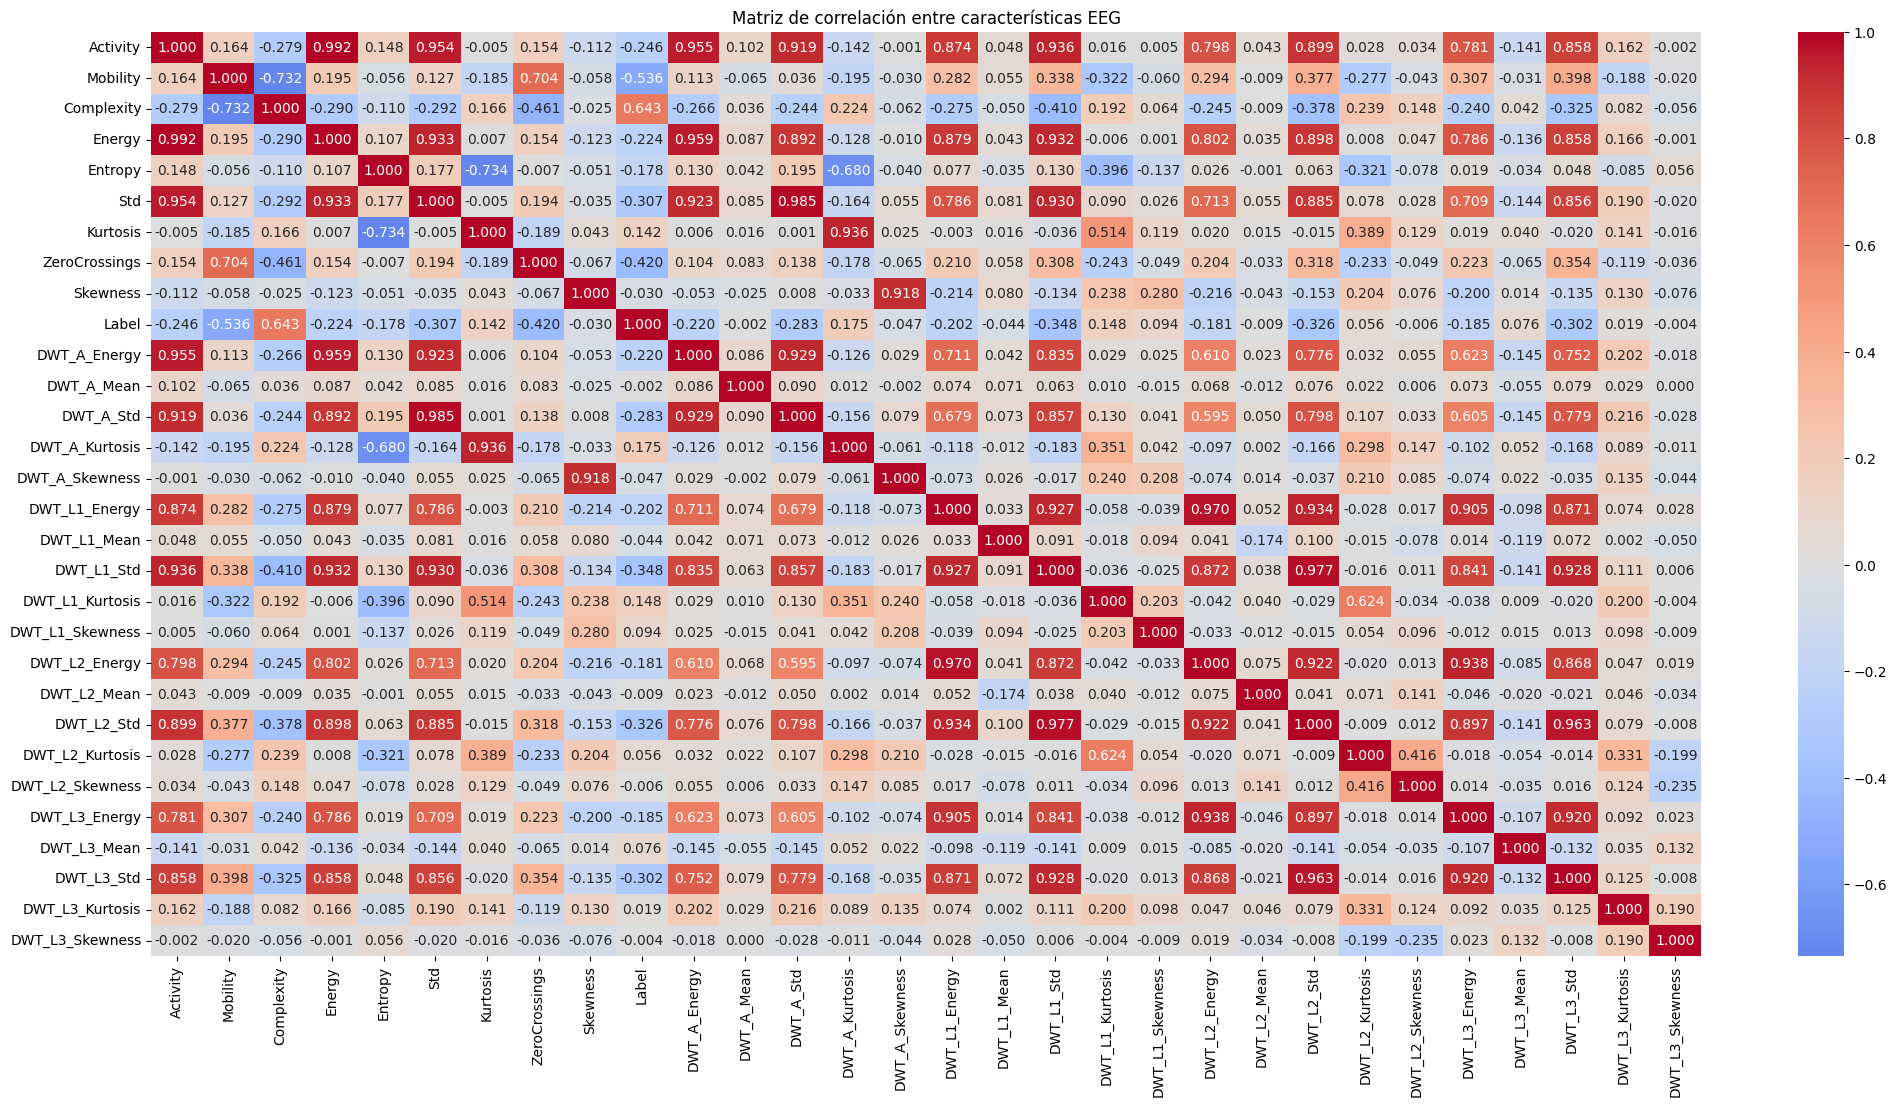

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 12))  # Tamaño grande
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap="coolwarm", center=0)
plt.title("Matriz de correlación entre características EEG")
plt.show()

Activity          -0.246
Mobility          -0.536
Complexity         0.643
Energy            -0.224
Entropy           -0.178
Std               -0.307
Kurtosis           0.142
ZeroCrossings     -0.420
Skewness          -0.030
Label              1.000
DWT_A_Energy      -0.220
DWT_A_Mean        -0.002
DWT_A_Std         -0.283
DWT_A_Kurtosis     0.175
DWT_A_Skewness    -0.047
DWT_L1_Energy     -0.202
DWT_L1_Mean       -0.044
DWT_L1_Std        -0.348
DWT_L1_Kurtosis    0.148
DWT_L1_Skewness    0.094
DWT_L2_Energy     -0.181
DWT_L2_Mean       -0.009
DWT_L2_Std        -0.326
DWT_L2_Kurtosis    0.056
DWT_L2_Skewness   -0.006
DWT_L3_Energy     -0.185
DWT_L3_Mean        0.076
DWT_L3_Std        -0.302
DWT_L3_Kurtosis    0.019
DWT_L3_Skewness   -0.004
Name: Label, dtype: float64


/tmp/ipython-input-14-2596399329.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_corr.values, y=label_corr.index, palette="viridis")


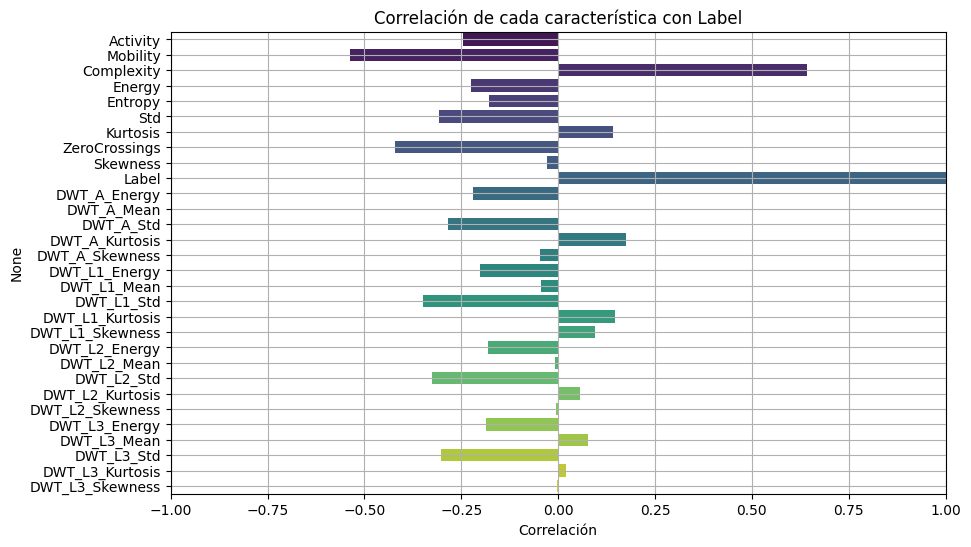

In [14]:

label_corr = features_df.drop(columns=["Origin"]).corr()['Label']
print(label_corr.round(3))
plt.figure(figsize=(10, 6))
sns.barplot(x=label_corr.values, y=label_corr.index, palette="viridis")
plt.title("Correlación de cada característica con Label")
plt.xlabel("Correlación")
plt.xlim(-1, 1)
plt.grid(True)
plt.show()


In [15]:

threshold = 0.2
selected_features = label_corr[abs(label_corr) >= threshold].index.tolist()
filtered_df = features_df[selected_features]
cols = [col for col in filtered_df.columns if col != 'Label'] + ['Label']
filtered_df = filtered_df[cols]

In [16]:
print (filtered_df)

         Activity  Mobility  Complexity      Energy         Std  \
0      819.394663  0.217637    4.740927   6701313.0   28.625071   
1    17815.768309  0.143801    3.557419  77128620.0  133.475722   
2     5177.966797  0.214105    2.907144  23778006.0   71.958091   
3     1428.958883  0.199027    4.179840  10945840.0   37.801572   
4     7104.007747  0.271187    2.762118  30095867.0   84.285276   
..            ...       ...         ...         ...         ...   
645  16006.860336  0.224413    2.887012   5185146.0  126.518221   
646  13316.717037  0.203155    6.319824   5837538.0  115.398081   
647  15495.940884  0.201801    2.501626   5785262.0  124.482693   
648  15133.883834  0.147357    5.203959   5935519.0  123.019851   
649  13004.255523  0.220692    3.402026   5190201.0  114.036203   

     ZeroCrossings  DWT_A_Energy   DWT_A_Std  DWT_L1_Energy  DWT_L1_Std  \
0              161  6.494952e+06   77.592879   1.851422e+05   18.901216   
1               72  7.466569e+07  368.810753 

In [18]:
filtered_df.to_csv(PATH_RESULTS+"/features/EEG_features_Classic.csv",sep=';', index=False)